# Computing the Value of a given Footbal Action and its probability of ending in Goal

Based on tutorial https://github.com/SciSports-Labs/fot-valuing-actions

In [1]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, brier_score_loss, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_calibration_curve


from xgboost import XGBClassifier


pd.options.mode.chained_assignment = None

# Load Data

The data comprises event data from Euro 2016. It was made publicly available by Wyscout (https://figshare.com/collections/Soccer_match_event_dataset/4415000).

The original data was first transformed into the SPADL structure and stored in a HDF5 file (spadl.h5), the data is organized in different datasets within the HDF5 file. This file **spadl.h5** will be used as the data source.

In order to obtain the data in this format check SciSports tutorial: https://github.com/SciSports-Labs/fot-valuing-actions/blob/master/notebooks/tutorial1-run-pipeline.ipynb


The analysis and modeling in this notebook is based on Actions. Each action is defined as a sequence of 3 consecutive events (ex: pass, shoot, tackle, ...)

In [2]:
#Datasets comprised on the spadl.h5 file

with pd.HDFStore('data/spadl.h5') as f:
    display("Datasets: ", f.keys())

'Datasets: '

['/actiontypes',
 '/bodyparts',
 '/games',
 '/player_games',
 '/players',
 '/results',
 '/teams',
 '/actions/game_1694390',
 '/actions/game_1694391',
 '/actions/game_1694392',
 '/actions/game_1694393',
 '/actions/game_1694394',
 '/actions/game_1694395',
 '/actions/game_1694396',
 '/actions/game_1694397',
 '/actions/game_1694398',
 '/actions/game_1694399',
 '/actions/game_1694400',
 '/actions/game_1694401',
 '/actions/game_1694402',
 '/actions/game_1694403',
 '/actions/game_1694404',
 '/actions/game_1694405',
 '/actions/game_1694406',
 '/actions/game_1694407',
 '/actions/game_1694408',
 '/actions/game_1694409',
 '/actions/game_1694410',
 '/actions/game_1694411',
 '/actions/game_1694412',
 '/actions/game_1694413',
 '/actions/game_1694414',
 '/actions/game_1694415',
 '/actions/game_1694416',
 '/actions/game_1694417',
 '/actions/game_1694418',
 '/actions/game_1694419',
 '/actions/game_1694420',
 '/actions/game_1694421',
 '/actions/game_1694422',
 '/actions/game_1694423',
 '/actions/game_16

## Load Teams

In [3]:
df_teams = pd.read_hdf('data/spadl.h5', key='teams')
display(df_teams.head())
df_teams.shape

,team_id,short_team_name,team_name
0,1613,Newcastle United,Newcastle United FC
1,692,Celta de Vigo,Real Club Celta de Vigo
2,691,Espanyol,Reial Club Deportiu Espanyol
3,696,Deportivo Alavés,Deportivo Alavés
4,695,Levante,Levante UD


(142, 3)

## Load Games

In [4]:
df_games = pd.read_hdf('data/spadl.h5', key='games')

In [5]:
display(df_games.head())
df_games.shape

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,1694440,102,9291,2016-07-10 19:00:00,9905,4418
1,1694439,102,9291,2016-07-07 19:00:00,3148,4418
2,1694438,102,9291,2016-07-06 19:00:00,9905,10682
3,1694437,102,9291,2016-07-03 19:00:00,4418,7839
4,1694436,102,9291,2016-07-02 19:00:00,3148,3757


(51, 6)

As we can see there are 51 games, which comprise all games on Euro 2016

## Load Features

These features are extracted from the different actions. As mentioned earlier, each action is defined as a sequence of 3 consecutive events (ex: pass, shoot, tackle, ...)


**Note:** *features.h5* file already contains a lot of features extracted from each action, these refer to features from event1, event2 and event3 of each action, as well as, some informative features from the action itself (ex: game score, game time, teams playing, ...).

In this case, the features were extracted for Euro 2016.

For more details about feature extraction, see: https://github.com/SciSports-Labs/fot-valuing-actions/blob/master/notebooks/tutorial2-generate-features.ipynb


In [6]:
with pd.HDFStore('data/features.h5') as f:
    display("Datasets: ", f.keys())

'Datasets: '

['/game_1694390',
 '/game_1694391',
 '/game_1694392',
 '/game_1694393',
 '/game_1694394',
 '/game_1694395',
 '/game_1694396',
 '/game_1694397',
 '/game_1694398',
 '/game_1694399',
 '/game_1694400',
 '/game_1694401',
 '/game_1694402',
 '/game_1694403',
 '/game_1694404',
 '/game_1694405',
 '/game_1694406',
 '/game_1694407',
 '/game_1694408',
 '/game_1694409',
 '/game_1694410',
 '/game_1694411',
 '/game_1694412',
 '/game_1694413',
 '/game_1694414',
 '/game_1694415',
 '/game_1694416',
 '/game_1694417',
 '/game_1694418',
 '/game_1694419',
 '/game_1694420',
 '/game_1694421',
 '/game_1694422',
 '/game_1694423',
 '/game_1694424',
 '/game_1694425',
 '/game_1694426',
 '/game_1694427',
 '/game_1694428',
 '/game_1694429',
 '/game_1694430',
 '/game_1694431',
 '/game_1694432',
 '/game_1694433',
 '/game_1694434',
 '/game_1694435',
 '/game_1694436',
 '/game_1694437',
 '/game_1694438',
 '/game_1694439',
 '/game_1694440']

In [7]:
dfs_features = []
#load feaures for a dataframe
for _, game in df_games.iterrows():
    game_id = game['game_id']
    
    #load all features for all actions of given game
    df_features = pd.read_hdf('data/features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
    
#create df_features (for all actions)
df_features = pd.concat(dfs_features).reset_index(drop=True)

display(df_features.head())
df_features.shape

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2,game_id
0,True,False,False,False,False,False,False,False,False,False,...,0.187731,80.158369,0.187731,80.158369,0.187731,True,True,0.000000,0.000000,1694440
1,True,False,False,False,False,False,False,False,False,False,...,0.354440,80.158369,0.187731,80.158369,0.187731,True,True,2.191167,2.191167,1694440
2,True,False,False,False,False,False,False,False,False,False,...,0.258985,78.371487,0.354440,80.158369,0.187731,True,True,2.557667,4.748834,1694440
3,True,False,False,False,False,False,False,False,False,False,...,0.176247,71.690861,0.258985,78.371487,0.354440,True,True,1.044167,3.601834,1694440
4,True,False,False,False,False,False,False,False,False,False,...,0.357874,85.321753,0.176247,71.690861,0.258985,True,True,3.048458,4.092625,1694440


(62697, 143)

## Load Labels


Similarly to the features extraction, the labels were also obtained using the code in: https://github.com/SciSports-Labs/fot-valuing-actions/blob/master/notebooks/tutorial2-generate-features.ipynb.


In [8]:
dfs_labels = []

#load labels for a dataframe
for _, game in df_games.iterrows():
    game_id = game['game_id']
    
    #load all features for all actions of given game
    df_labels = pd.read_hdf('data/labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
    
#create df_labels (for all actions)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

#drop and renaming columns
df_labels.drop(['concedes'], axis = 1, inplace = True)
df_labels.rename(columns={'scores':'goal'}, inplace=True)

display(df_labels)
df_labels.shape

,goal,game_id
0,False,1694440
1,False,1694440
2,False,1694440
3,False,1694440
4,False,1694440
...,...,...
62692,False,1694390
62693,False,1694390
62694,False,1694390
62695,False,1694390


(62697, 2)

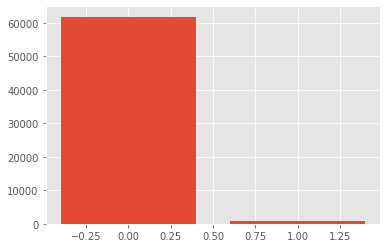

In [9]:
dist = dict(df_labels['goal'].value_counts())
plt.bar(dist.keys(), dist.values())
plt.show()


# Machine Learning Model


A Machine Learning model (XGClassifier) will be trained and tuned with the goal of predicting if a given action will result in a goal in the next 10 actions, or not.

This will also allow to value an action, depending on the probability of a given action result in a goal, or not

In [254]:
#split train and test data, using the same class ratio on the two sets
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    df_labels['goal'],
    test_size=0.10,
    stratify=df_labels['goal']
)

Classes ratio - Train set


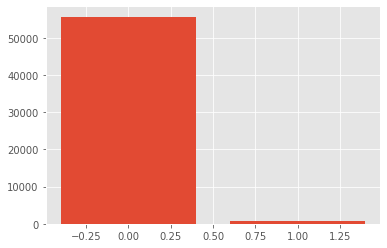

Classes ratio - Test set


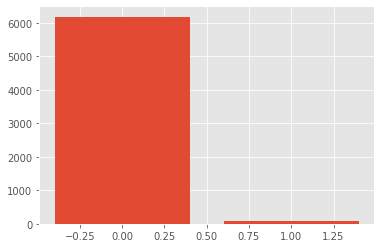

In [255]:
print('Classes ratio - Train set')
dist = dict(y_train.value_counts())
plt.bar(dist.keys(), dist.values())
plt.show()

print('Classes ratio - Test set')

dist = dict(y_test.value_counts())
plt.bar(dist.keys(), dist.values())
plt.show()


## Naive Approach (Baseline)

The default hyperparemeters of the ML model and a set of fixed features will be used

### Features to use


In [256]:
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]

In [271]:
X_train.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2,game_id,home_ranking,away_ranking
58897,True,False,False,False,False,False,False,False,False,False,...,0.411519,67.399918,0.192885,True,True,0.018490,6.527140,1694397,3,7
46528,True,False,False,False,False,False,False,False,False,False,...,1.039072,36.668248,0.730991,True,True,0.017505,7.045435,1694392,15,12
20776,False,False,False,False,True,False,False,False,False,False,...,0.157924,13.724198,0.407571,False,False,0.162516,18.242747,1694419,21,9
18713,True,False,False,False,False,False,False,False,False,False,...,0.168804,40.533395,0.289212,False,True,-0.017314,2.752258,1694426,12,18
55,True,False,False,False,False,False,False,False,False,False,...,0.561922,40.052466,0.746548,False,False,0.005002,2.921140,1694440,5,6


### Model Training

A naive model will be trained using the default hyperparameters, and will be later tuned and improved using different techniques


In [258]:
#XGBoost model

model = XGBClassifier()    
model.fit(X_train[features], y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predictions using default hyperparameters

In [259]:
def make_predictions(m, X_data):
    
    #binary classification
    y_pred = m.predict(X_data)

    #Action value
    probabilities = m.predict_proba(X_data)
    
    #probability of Goal (class 1)
    y_pred_prob = probabilities[:, 1]
    
    return y_pred, y_pred_prob


y_pred, y_pred_prob = make_predictions(model, X_test[features])

## Evaluate Results

For evaluating the results obtained, the most common classification metrics will be used.

Furthermore, a calibration diagram will be plotted with the goal of assessing whether the predictions follow the original data ditribution or not, that is, if they are calibrated or not.


In [273]:
def evaluate_results(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print("\nTrue Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("Falso Positives:", cm[0][1])
    print("True Positives:", cm[1][1])


    
    print("Accuracy: ", round(accuracy_score(y_test, y_pred) ,3))
    print("Recall: ", round(recall_score(y_test, y_pred) ,3))
    print("Precision: ", round(precision_score(y_test, y_pred) ,3))

evaluate_results(y_test, y_pred)

Confusion Matrix:
 [[6179    4]
 [  82    5]]

True Negatives: 6179
False Negatives: 82
Falso Positives: 4
True Positives: 5
Accuracy:  0.986
Recall:  0.057
Precision:  0.556


**Calibration Plot**

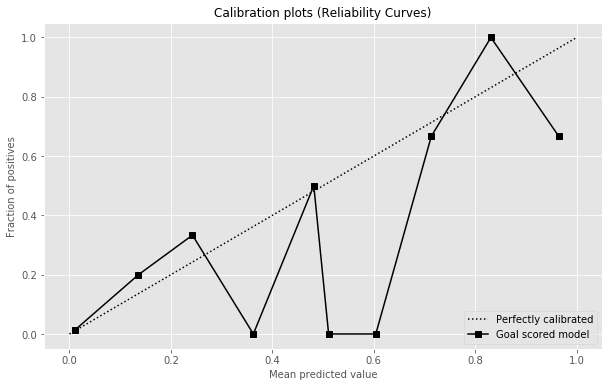

In [260]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_calibration_curve(
    y_true=y_test.values,
    probas_list=[list(y_pred_prob)],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax = ax
)

plt.show()

As we can see the results could still be improved. In particular, the number of False Negatives is significant, which means that there are some actions that will lead to a goal and were labeled as not.

## Model Tuning

In order to try to improve the model prediction, some tuning techniques were applied, namely: techinques of **Feature Selection**, **Data Normalization** and **Hyperparameter tuning**.

### Feature Selection

In order to select the best features to be used in the model, two different methods will be applied (in a boosting approach):
1. Based on features variance: Only the features with a significant variance will be selected
2. Based on the Lasso method: Only the features with a posiive coeficient will be selected


In [262]:
#FEATURE SELECTION

#1. Select Features with a minimum of variance

model_variance = VarianceThreshold(threshold=.1)
model_variance.fit(X_train)


new_features = X_train.columns[model_variance.get_support()]


#2. Select features with positive coeficients after applying Lasso

model_lasso = LassoCV(cv = 5, tol = 0.01, max_iter = 5000)
model_lasso.fit(X_train[new_features], y_train)

coef = pd.Series(model_lasso.coef_, index = X_train[new_features].columns)
relevant_features = [i for i in coef.index if coef[i] > 0.0]


#add nation ranking as a relevant feature

#nations ranking before Euro 2016
nations_ranking = {
    9905: 5,
    3148: 2,
    4418: 6,
    10682: 51,
    13869: 18,
    2413: 3,
    3757: 4,
    10451: 33,
    9598: 17,
    6697: 12,
    7047: 21,
    7839: 35,
    11555: 13,
    14622: 8,
    10962: 46,
    14496: 31,
    14358: 7,
    11944: 15,
    5629: 9,
    1598: 1,
    9109: 16,
    8274: 41,
    4687: 11,
    8731: 39   
}

rankings = []

#ADD home_ranking AND away_ranking FEATURES TO TRAINING SET
for ind, row in X_train.iterrows():
    game_id = row['game_id']
    home_team_id = df_games.loc[df_games.game_id == game_id]['home_team_id'].values[0]
    away_team_id = df_games.loc[df_games.game_id == game_id]['away_team_id'].values[0]
    
    rankings.append([nations_ranking[home_team_id], nations_ranking[away_team_id]])
    

X_train.loc[:, 'home_ranking'] = np.array(rankings)[:, 0]
X_train.loc[:, 'away_ranking'] = np.array(rankings)[:, 1]


relevant_features.extend(['home_ranking', 'away_ranking'])


print("Set of Features Selected: ", relevant_features)


Set of Features Selected:  ['result_success_a0', 'goalscore_team', 'goalscore_opponent', 'end_y_a0', 'end_y_a2', 'dy_a0', 'movement_a0', 'dx_a2', 'dy_a2', 'movement_a2', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a1', 'start_dist_to_goal_a2', 'end_angle_to_goal_a0', 'end_dist_to_goal_a1', 'end_angle_to_goal_a2', 'time_delta_1', 'game_id', 'home_ranking', 'away_ranking']


One interesting fact, is that there is no relevance in being the home team or the away team, as all were in the same country (France)

In [263]:
#ADD home_ranking AND away_ranking FEATURES TO TESTING SET

rankings = []

for ind, row in X_test.iterrows():
    game_id = row['game_id']
    home_team_id = df_games.loc[df_games.game_id == game_id]['home_team_id'].values[0]
    away_team_id = df_games.loc[df_games.game_id == game_id]['away_team_id'].values[0]
    
    rankings.append([nations_ranking[home_team_id], nations_ranking[away_team_id]])
    

X_test.loc[:, 'home_ranking'] = np.array(rankings)[:, 0]
X_test.loc[:, 'away_ranking'] = np.array(rankings)[:, 1]

### Normalizing Data

In [264]:
continuous_columns = ['end_y_a0', 'end_x_a2', 'end_y_a2', 'dy_a0', 'movement_a0', 'dx_a2', 'dy_a2', 'mov_a02', 'start_dist_to_goal_a1', 'end_angle_to_goal_a0', 'end_dist_to_goal_a1', 'time_delta_1', ]

sc = StandardScaler()
X_train[continuous_columns] = sc.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = sc.transform(X_test[continuous_columns])


In [269]:
X_train[relevant_features]

,result_success_a0,goalscore_team,goalscore_opponent,end_y_a0,end_y_a2,dy_a0,movement_a0,dx_a2,dy_a2,movement_a2,...,mov_a02,start_dist_to_goal_a1,start_dist_to_goal_a2,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a2,time_delta_1,game_id,home_ranking,away_ranking
58897,True,0,1,-0.591428,0.631709,0.658092,-0.145426,-1.421661,-0.220613,26.469275,...,1.187567,0.403739,43.108612,-0.749792,-0.255239,0.192885,0.018490,1694397,3,7
46528,True,0,1,1.223507,1.225481,-0.274412,-0.912202,1.074331,0.670702,22.406305,...,-0.586663,-0.913601,49.360722,1.246946,-1.097930,0.730991,0.017505,1694392,15,12
20776,True,0,0,-0.696135,-0.311340,-1.162511,0.680638,0.109970,-1.067362,16.454556,...,2.038916,-1.897119,18.288368,-0.345454,0.268401,0.407571,0.162516,1694419,21,9
18713,False,0,0,-0.556525,-0.625690,-0.230007,-0.943173,0.790695,-0.666270,17.892177,...,-1.004486,-0.747918,53.567267,-0.446624,-0.781762,0.289212,-0.017314,1694426,12,18
55,True,0,0,-1.219674,-1.429028,0.036423,-1.162305,-0.230392,0.447873,7.992496,...,-0.730690,-0.768534,42.320681,0.413706,-0.601152,0.746548,0.005002,1694440,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38015,True,0,0,0.595260,-0.730473,0.702497,-0.514090,0.733968,-1.646717,28.624257,...,-0.342656,-0.763404,52.732685,-0.210412,-0.941134,0.345368,0.011488,1694411,1,11
16744,False,0,0,0.455650,1.435048,0.125232,-1.156339,-1.364934,0.759833,27.724963,...,0.357108,0.894720,51.204394,-0.780193,0.027922,0.370616,0.003610,1694428,17,5
47243,True,1,1,-0.242402,1.469975,-0.896081,-0.178275,1.584875,3.255515,57.693064,...,0.370616,-1.015864,45.750000,-0.637294,-1.237011,1.194602,-0.003978,1694392,15,12
3194,True,0,0,0.979189,-0.451051,-0.407627,-0.480439,-0.173665,0.447873,7.494164,...,0.900889,-0.651387,41.630807,-0.230254,-0.362489,0.191895,0.027847,1694438,5,51


### Hyperparameter tuning using Cross Validation and Grid Search

Best Parms {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10}
Confusion Matrix:
 [[6182    1]
 [  77   10]]

True Negatives: 6182
False Negatives: 77
Falso Positives: 1
True Positives: 10
Recall:  0.115
Precision:  0.909


Calibration Diagram:



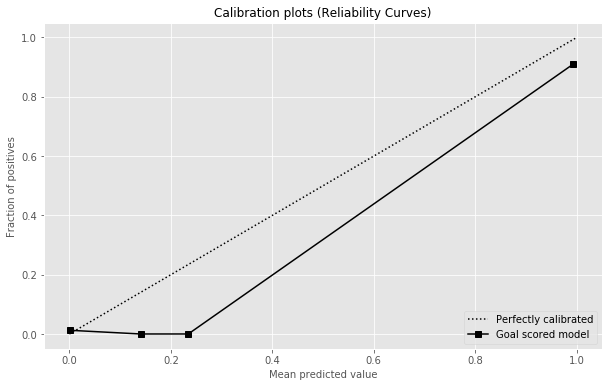

In [270]:
parameters = {
    'max_depth': [3, 10],
    'n_estimators': [10, 20, 100],
    'learning_rate': [0.05]
}

#Cross Validation and Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring=make_scorer(brier_score_loss),
    refit=True,
    cv = 3
)


grid_search.fit(X_train[relevant_features], y_train)
print("Best Parms", grid_search.best_params_)
best_model = grid_search.best_estimator_

#predict and evaluate results
y_pred_tuned, y_pred_prob_tuned = make_predictions(best_model, X_test[relevant_features])
evaluate_results(y_test, y_pred_tuned)


#reliability plot
print("\n\nCalibration Diagram:\n")
fig, ax = plt.subplots(figsize = (10, 6))
plot_calibration_curve(
    y_true=y_test.values,
    probas_list=[list(y_pred_prob_tuned)],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax = ax
)

plt.show()

As we could see the data appears to be more calibrated (the data points are closer to the dotted line). 
Also, in terms of results, the tuned model presented better results of precision, accuracy and recall comparing to the Naive model.

As a reminder, the new model was obtained by tuning the original and naive model, through feature selection, data normalization and hyperparameters tuning.


Using the trained model, we obtain the probability of a given action result in goal, based on the previous sequence of events. Considering that a value of an action corresponds to the probability of ending in goal, the results obtained correspond directly to the actions values.